In [144]:
%%capture
!pip install plotly
!pip install alpha_vantage
!pip install quandl
!pip install --upgrade plotly
!pip install --upgrade notebook
!pip install arch
!pip install cvxpy

In [145]:
from alpha_vantage.timeseries import TimeSeries
import quandl
import matplotlib.pyplot as plt
import config 
import plotly.express as px
import pandas as pd
import os
import numpy as np
import datetime
import plotly.io as pio
pio.renderers.default = 'notebook'
from arch import arch_model
import cvxpy as cp

In [127]:
def write_date_to_file(file_path):
    today_date = datetime.datetime.today().strftime("%Y-%m-%d")
    with open(file_path, "w") as file:
        file.write(today_date)

# Function to read the date from the file
def read_date_from_file(file_path):
    with open(file_path, "r") as file:
        saved_date = file.read().strip()
    return saved_date



In [155]:

# Initialize the TimeSeries object with your API key
ts = TimeSeries(key=config.api_key, output_format='pandas')

subfolder='data/'

# Define the symbols and their corresponding dollar investments in your portfolio




def plot_portfolio_growth(portfolio,investment_date):

    date_path = 'last_fetched.txt'

    #### Check if the data was recently updated.

    if not os.path.exists(date_path):
        write_date_to_file(date_path)
    saved_date = read_date_from_file(date_path)
    today_date = datetime.datetime.today().strftime("%Y-%m-%d")
    # Compare the saved date and today's date
    if saved_date < today_date:
        rewrite_data = True
        write_date_to_file(date_path)
    else:
        rewrite_data = False
        


    initial_investment = sum(portfolio.values())

    # Create an empty DataFrame to store the daily returns
    global portfolio_returns
    portfolio_returns = pd.DataFrame()

    # Initialize a cumulative portfolio return variable
    cumulative_portfolio_return = 0

    # Fetch daily historical stock data and calculate returns for each symbol
    for symbol, investment in portfolio.items():    
        data_path = os.path.join(subfolder, 'portfolio_data_' + symbol.replace('.','_') + '.parquet')
        print("rewriting data? : ",((not os.path.exists(data_path)) | rewrite_data))
        global data
    # To prevent repeated API calls
        if ((not os.path.exists(data_path)) | rewrite_data):
            data, _ = ts.get_weekly_adjusted(symbol=symbol)
            
        else:
            data = pd.read_parquet(data_path)


        data = data.sort_values(by='date')




        data['Returns'] = data['5. adjusted close'].astype(float).pct_change()
        data = data[data.index >= investment_date]  # Filter data from the start date
        data=data.reset_index()
        data.loc[0,'investment_value'] = investment
        data['holding_size'] = investment/data.loc[0,'5. adjusted close']
        data['investment_value'] = data['holding_size'] * data['5. adjusted close']

        portfolio_returns[symbol] = data['investment_value']
        
    portfolio_returns = portfolio_returns.dropna()
    
    global portfolio_returns_df
    portfolio_returns_df = pd.concat([portfolio_returns,data['date']],axis=1)




    # Calculate the cumulative portfolio returns
    global cumulative_portfolio_returns
    cumulative_portfolio_returns = portfolio_returns.sum(axis=1)

    # Calculate the total portfolio value in dollar terms
    portfolio_value = pd.concat([cumulative_portfolio_returns,data['date']],axis=1)
    portfolio_value.columns=['value','date']


    # Set a dark theme style
    plt.style.use('dark_background')

    # Create a figure and axis
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # Plot the data with a green line and circular markers
    plt.plot(portfolio_value['date'], portfolio_value['value'], label='Portfolio Value ($)', color='red', marker='o', markersize=3)

    # Add a title with white text
    plt.title('Growth in Portfolio Value Over Time', fontsize=16, color='white')

    # Customize the x-axis and y-axis labels with white text
    plt.xlabel('Date', fontsize=12, color='white')
    plt.ylabel('Portfolio Value', fontsize=12, color='white')

    # Add a grid with dashed lines and adjust transparency
    plt.grid(True, linestyle='--', alpha=0.4)

    # Customize the legend with white text
    plt.legend(loc='upper left', fontsize=12, edgecolor='white', facecolor='black')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, color='white')

    # Set the background color to black
    ax.set_facecolor('black')

    # Display the plot
    plt.tight_layout()
    plt.show()
    


    df = portfolio_returns_df

    # Convert the 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Set the 'date' column as the index (optional)
    # df.set_index('date', inplace=True)

    # Set a dark theme style
    plt.style.use('dark_background')

    # Create a figure and axis
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # Plot the three time series on the same plot with custom colors

    stocks = list(portfolio.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(stocks)))

    for i,col in enumerate(stocks):
        color = colors[i]
        plt.plot(df['date'], df[col], label=col, color=color, linestyle='-', marker='o', markersize=3)


    # Customize the plot with white text and a dark background
    plt.title('Individual Portfolio holdings', fontsize=16, color='white')
    plt.xlabel('Date', fontsize=12, color='white')
    plt.ylabel('Value', fontsize=12, color='white')
    plt.legend(fontsize=12, edgecolor='white', facecolor='black')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.xticks(rotation=45, color='white')
    ax.set_facecolor('black')

    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return(portfolio_value)

rewriting data? :  False
rewriting data? :  False
rewriting data? :  False
rewriting data? :  False


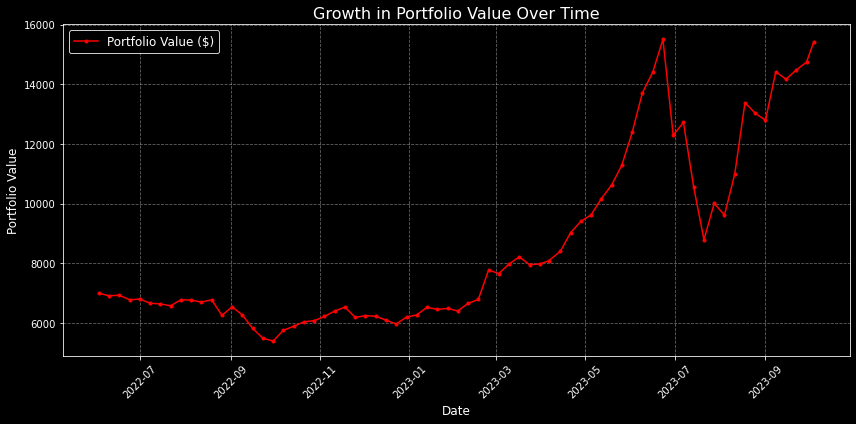

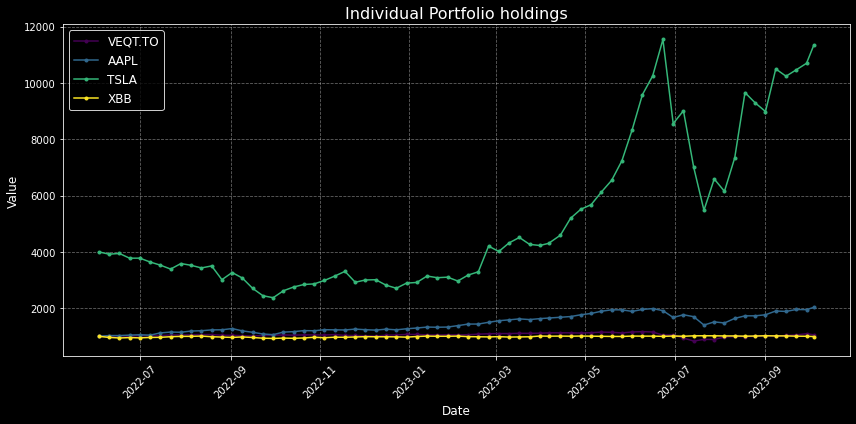

rewriting data? :  False
rewriting data? :  False
rewriting data? :  False


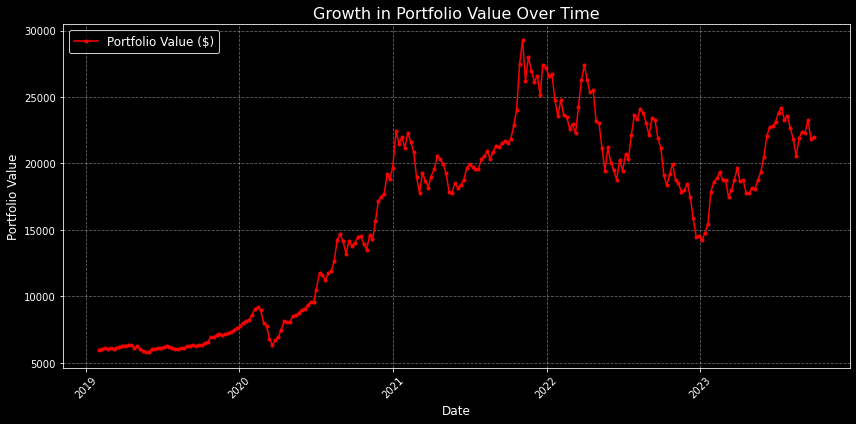

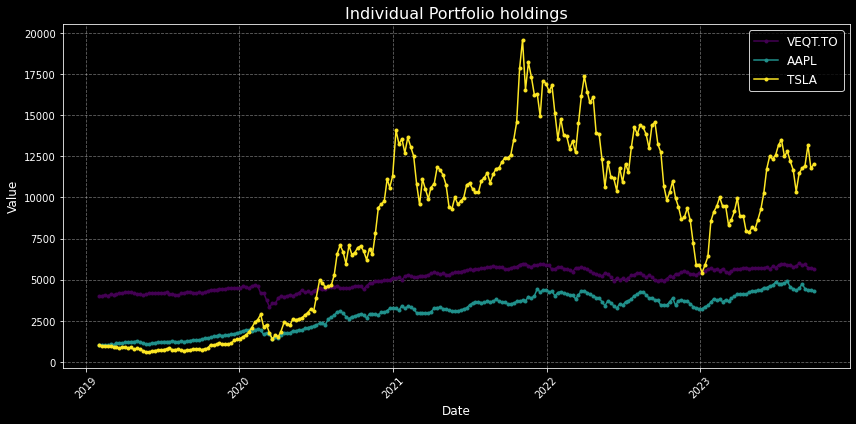

In [176]:


### Try with different portfolio combinations
portfolio_1 = {
    'VEQT.TO': 1000,
    'AAPL': 1000,  
    'TSLA': 4000,
    'XBB' : 1000
}

portfolio_2 = {
    'VEQT.TO': 4000, 
    'AAPL': 1000,  
    'TSLA': 1000
}

investment_date = '2019-02-01'


for i in [portfolio_1,portfolio_2]:
    plot_portfolio_growth(i,investment_date)

In [173]:
#Constructing a Risk optimal portfolio using just the returns data

##### Inputs ##
##############

symbols = ['AAPL','VEQT.TO','NVDA','VAB.TO']
initial_investment = 1000000


##############
##############
    
    
#### Fetch the initial data again
portfolio_returns = pd.DataFrame()

for symbol in symbols:    
    data_path = os.path.join(subfolder, 'portfolio_data_' + symbol.replace('.','_') + '.parquet')
    print("rewriting data? : ",((not os.path.exists(data_path)) | rewrite_data))
    global data
# To prevent repeated API calls
    if ((not os.path.exists(data_path)) | rewrite_data):
        data, _ = ts.get_weekly_adjusted(symbol=symbol)

        ### Replace with daily adjusted if premium key
#            data,_ = ts.get_daily_adjusted(symbol=symbol, interval='5min', outputsize='full')
        data.to_parquet(data_path)
    else:

        data = pd.read_parquet(data_path)


    data = data.sort_values(by='date')




    data['Returns'] = data['5. adjusted close'].astype(float).pct_change()
    data = data[data.index >= investment_date]  # Filter data from the start date
    data=data.reset_index()


    portfolio_returns[symbol] = data['Returns']


cov_matrix = portfolio_returns.cov()

# Define the number of assets and initial investment
num_assets = len(df.columns)



# Define the portfolio weights as variables to optimize
weights = cp.Variable(num_assets)
# Define the risk parity objective function
risk_contribution = cp.matmul(cov_matrix, weights)
risk_parity_objective = cp.norm(risk_contribution, 'fro')

rewriting data? :  False
rewriting data? :  False
rewriting data? :  False
rewriting data? :  False


In [174]:
weights

Variable((4,))

rewriting data? :  False
rewriting data? :  False
rewriting data? :  False
rewriting data? :  False
Allocate $435.24 to AAPL
Allocate $2506.97 to VEQT.TO
Allocate $3169.19 to VFV.TO
Allocate $3888.6 to TLT


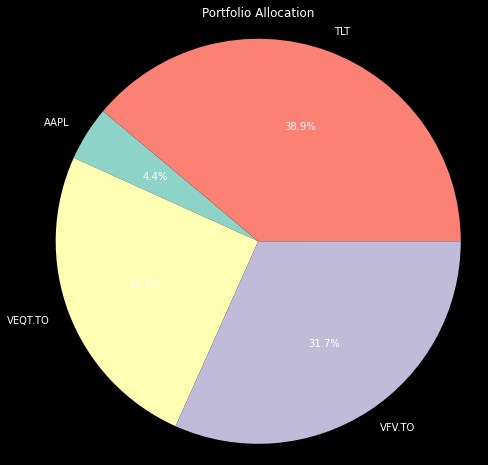

In [195]:
############# Inputs:
####################

symbols = ['AAPL','VEQT.TO','VFV.TO','TLT']
initial_investment = 10000 
risk_free_rate = 0.03


# Fetch daily historical stock data and calculate returns for each symbol
portfolio_returns = pd.DataFrame()
for symbol in symbols:    
    data_path = os.path.join(subfolder, 'portfolio_data_' + symbol.replace('.','_') + '.parquet')
    print("rewriting data? : ",((not os.path.exists(data_path)) | rewrite_data))
    global data
# To prevent repeated API calls
    if ((not os.path.exists(data_path)) | rewrite_data):
        data, _ = ts.get_weekly_adjusted(symbol=symbol)

        ### Replace with daily adjusted if premium key
#            data,_ = ts.get_daily_adjusted(symbol=symbol, interval='5min', outputsize='full')
        data.to_parquet(data_path)
    else:

        data = pd.read_parquet(data_path)


    data = data.sort_values(by='date')




    data['Returns'] = data['5. adjusted close'].astype(float).pct_change()
    data = data[data.index >= investment_date]  # Filter data from the start date
    data=data.reset_index()
    portfolio_returns[symbol] = data['Returns']
    
    


# Calculate the covariance matrix
cov_matrix = portfolio_returns.cov()

# Define number of assets
num_assets = len(symbols)


### Initialize weights to 0
weights = cp.Variable(num_assets)

# Define the risk parity objective function
risk_contribution = cp.matmul(cov_matrix, weights)
risk_parity_objective = cp.norm(risk_contribution, 'fro')

#### Define Constraints
constraints = [cp.sum(weights) == 1, weights >= 0]
### Define Problem and solve
problem = cp.Problem(cp.Minimize(risk_parity_objective), constraints)
problem.solve()

optimal_weights = weights.value
allocation = (initial_investment * optimal_weights).round(2)


#Print the allocation
for asset, alloc in zip(symbols, allocation):
    print(f"Allocate ${alloc} to {asset}")
    
    
    
### make a graph

# Create a pie chart to visualize allocation
plt.figure(figsize=(8, 8))
plt.pie(allocation, labels=symbols, autopct='%1.1f%%', startangle=140)
plt.title('Portfolio Allocation')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [189]:
cov_matrix

,AAPL,VEQT.TO,VFV.TO,NVDA
AAPL,1.625703e-03,-0.000058,-9.500255e-07,0.001555
VEQT.TO,-5.793010e-05,0.000475,6.893156e-05,0.000048
VFV.TO,-9.500255e-07,0.000069,5.274275e-04,0.000012
NVDA,1.554963e-03,0.000048,1.243687e-05,0.004193


In [133]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=5min&apikey=demo'
r = requests.get(url)
data = r.json()

pd.DataFrame(data).head()

,Meta Data,Time Series (5min)
1. Information,"Intraday (5min) open, high, low, close prices ...",NaN
2. Symbol,IBM,NaN
3. Last Refreshed,2023-10-04 19:50:00,NaN
4. Interval,5min,NaN
5. Output Size,Compact,NaN


In [181]:
data

,date,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,Returns
0,2019-02-01,136.55,146.7900,131.00,144.73,35.9044,152689768.0,0.00,-0.096285
1,2019-02-08,145.37,155.6000,144.13,148.17,36.7578,71805427.0,0.00,0.023769
2,2019-02-15,146.39,163.8700,144.50,157.34,39.0327,100890638.0,0.00,0.061889
3,2019-02-22,156.91,161.2600,155.18,159.19,39.4916,48579252.0,0.00,0.011757
4,2019-03-01,162.56,165.2800,153.11,156.45,38.8522,58171676.0,0.16,-0.016191
...,...,...,...,...,...,...,...,...,...
240,2023-09-08,482.23,488.5081,451.52,455.72,455.7200,175855198.0,0.04,-0.060466
241,2023-09-15,461.48,461.6300,438.08,439.00,439.0000,209850495.0,0.00,-0.036689
242,2023-09-22,427.48,442.4200,409.80,416.10,416.1000,217041499.0,0.00,-0.052164
243,2023-09-29,415.91,441.4400,411.77,434.99,434.9900,208880097.0,0.00,0.045398
